Imports

In [3]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

sys.path.insert(0,'../')
from environment import env
config = env.env()

#Import Models
sys.path.insert(0,'../03_nps_models')
from model_functions.tfidf_model import *
from model_functions.spacy_model import *
from model_functions.nltk_model import *
#from model_functions.gpt_model_functions import *
from model_functions import gpt_model_functions

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lauralyns/Documents/MADS/SIADS 699 -
[nltk_data]     Capstone/Capstone
[nltk_data]     VS/MADS_Capstone/.venv/lib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lauralyns/Documents/MADS/SIADS 699 -
[nltk_data]     Capstone/Capstone
[nltk_data]     VS/MADS_Capstone/.venv/lib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lauralyns/Documents/MADS/SIADS 699 -
[nltk_data]     Capstone/Capstone
[nltk_data]     VS/MADS_Capstone/.venv/lib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [78]:
.03*30145/200

4.52175

In [46]:
.11*30145/117

28.34145299145299

Test Data

In [4]:
test_data = pd.read_csv('../02_nps_api_data/testing_queries.csv')
test_data.columns = ['query', 'intent', 'endpoint', 'parkcode']
#Shuffling the Dataframe so that it will still be a random sample if it reaches OpenAI API or cost limits.
test_data = test_data.sample(frac=1, random_state=42)
test_data.head()

,query,intent,endpoint,parkcode
27641,What are the fees for visiting Virgin Islands ...,feespass,feespasses,vicr
15777,What is available at Denali National Park & Pr...,amenities,amenities,dena
24454,What events are scheduled at Lower Delaware?,events,events,lode
6328,What is the address of Saint Paul's Church,address,parks,sapa
28771,What are the fees for visiting Grant-Kohrs Ranch,feespass,feespasses,grko


In [3]:
len(test_data)

30144

Models

In [5]:
spacy_model = spacy_model_functions #from spacy_model.py
nltk_model = nltk_model #from nltk_model.py
tfidf_model = tfidf_model #from nltk_model.py
gpt_model = gpt_model_functions #from gpt_model_functions.py

models = {'gpt': gpt_model,
          'spacy': spacy_model, 
          'nltk' : nltk_model,
          'tfidf': tfidf_model,
          }

Test Output

In [7]:
def test_output(query, models):
    for model in models:
        start = time.time()
        endpoint, park_code, intent = models[model].get_params(query)
        stop = time.time()
        duration = stop-start
        print(model, ':', endpoint, park_code, intent, round(duration,3), 'sec')

In [8]:
query = 'What state is Green Springs in?'
test_output(query, models)

gpt : parks grsp state 2.272 sec
spacy : parks grsp state 0.026 sec
nltk : parks grsp state 0.03 sec
tfidf : parks grsp state 0.02 sec


In [16]:
query = 'List the amenities at Zion'
test_output(query, models)

gpt : amenities zion amenities 1.928 sec
spacy : parks None other 0.014 sec
nltk : parks None other 0.044 sec
tfidf : amenities zion amenities 0.017 sec


In [17]:
query = 'What is the fee for Yosemite?'
test_output(query, models)

gpt : fees yose feespass 2.142 sec
spacy : parks None other 0.015 sec
nltk : parks None other 0.048 sec
tfidf : feespasses yose feespass 0.016 sec


In [5]:
query = 'What activities are at canyonlands?'
test_output(query, models)

gpt : events cany events 1.757 sec
spacy : parks None other 0.02 sec
nltk : parks None other 0.044 sec
tfidf : events cany events 0.017 sec


In [6]:
query = 'What can you do at canyonlands?'
test_output(query, models)

gpt : amenities cany feespass 2.144 sec
spacy : parks None other 0.015 sec
nltk : parks None other 0.043 sec
tfidf : alerts cany alerts 0.017 sec


In [7]:
query = 'What alerts are at bryce?'
test_output(query, models)

gpt : alerts brca alerts 1.577 sec
spacy : parks None other 0.014 sec
nltk : parks None other 0.043 sec
tfidf : alerts brca alerts 0.021 sec


Create Test Output Data Frame

In [9]:
def create_test_data (query_df, models, n=0):
    """ Input: query_df is test data in a data frame with query, intent, endpoing, and parkcode
            models is a dictionary with model names as keys and models as values for models to be tested
            n is an optional parameter, which allows testing to resume from partway through if necessary
        Output:  test_df is the test data frame with predicted intent, endpoint and parkcode, for each model saved to test_data.pkl file as well
            times is a ? of the times it took for each 1k iteration of queries for each model tested
    """
        
    while n < len(query_df):
        segment_df = query_df[n:n+1000]
        segment_time = []
        for model in models:
            start = time.time()
            tempt_df = segment_df.apply(lambda x: models[model].get_params(x['query']), result_type='expand', axis=1)
            stop = time.time()
            
            tempt_df.columns = [f'{model}_endpoint', f'{model}_parkcode', f'{model}_intent']
            segment_df = pd.concat([segment_df, tempt_df], axis=1)
            segment_df = segment_df.fillna('none')
        
            segment_time.append((stop-start)/len(segment_df))
     
        if n ==0:
            test_df = segment_df
            times = pd.DataFrame(columns=models.keys())
        else:
            test_df = pd.read_pickle('test_data.pkl')
            test_df = pd.concat([test_df, segment_df], axis=0)
            times = pd.read_pickle('times.pkl')
            
        times.loc[n] = segment_time
        test_df.to_pickle('test_data.pkl')
        times.to_pickle('times.pkl')
        n=n+1000
        print(n, 'completed')

In [1]:
#Only run if test_data.pkl and times.pkl do not exits
#Takes 15+ hours to run and costs ~$25 dollars through OpenAI calls

#create_test_data(test_data, models)


In [8]:
times = pd.read_pickle('times.pkl')
times.head(2)

,gpt,spacy,nltk,tfidf
1000,1.901767,0.009635,0.026306,0.014053
2000,1.904685,0.011351,0.025409,0.014472


In [9]:
test_data = pd.read_pickle('test_data.pkl')
print(len(test_data))
test_data.head(2)

30144


,query,intent,endpoint,parkcode,gpt_endpoint,gpt_parkcode,gpt_intent,spacy_endpoint,spacy_parkcode,spacy_intent,nltk_endpoint,nltk_parkcode,nltk_intent,tfidf_endpoint,tfidf_parkcode,tfidf_intent
27641,What are the fees for visiting Virgin Islands ...,feespass,feespasses,vicr,fees,vicr,feespass,parks,vicr,other,parks,vicr,other,feespasses,vicr,feespass
15777,What is available at Denali National Park & Pr...,amenities,amenities,dena,amenities,dena,amenities,parks,dena,other,parks,dena,other,amenities,dena,amenities


Model Accuracy

In [11]:
metrics = ['intent', 'endpoint', 'parkcode']

In [12]:
def plot_accuracy(df, metric): 
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df[metric], palette='YlGn')
    plt.xlabel('API Model')
    plt.ylabel('Accuracy')
    plt.title(f'Model Accuracy on {metric.capitalize()}')
    plt.show()

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_70290/3266048973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


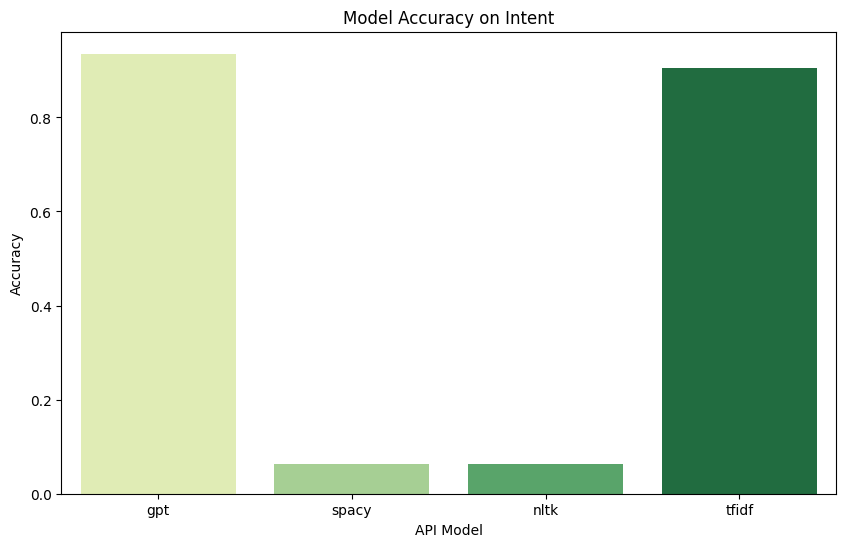

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_70290/3266048973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


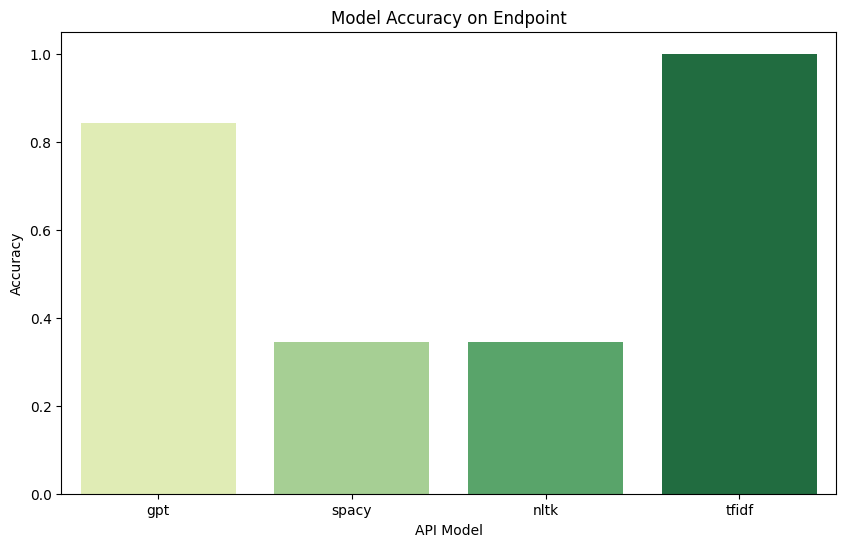

/var/folders/lq/0q3fzmb57s3c187k6gjyx3_00000gn/T/ipykernel_70290/3266048973.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[metric], palette='YlGn')


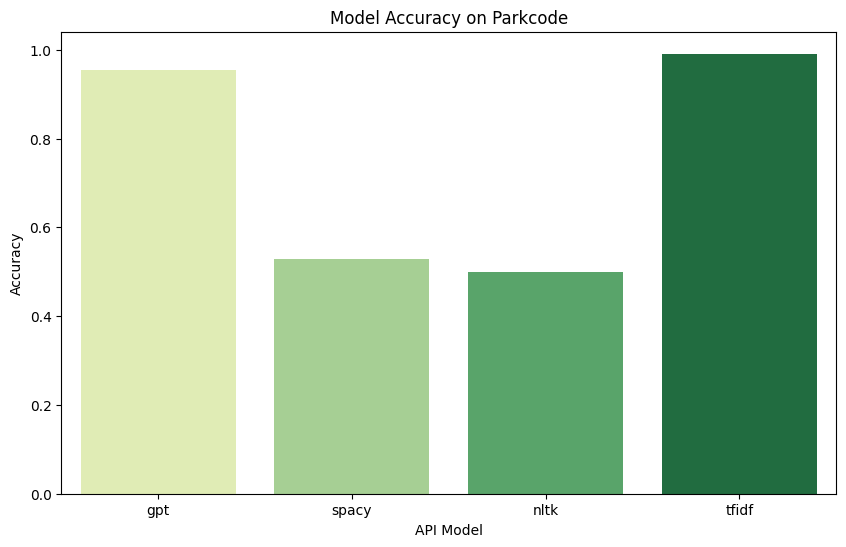

In [13]:
def model_accuracy (df, metrics, models):
    acc_df = pd.DataFrame(columns = metrics)
    for metric in metrics:
        for model in models:
            acc_df.loc[model,metric] = len(df.query(f'{metric}=={model}_{metric}'))/len(df)
        plot_accuracy(acc_df, metric)
    return acc_df

accuracy_df = model_accuracy(test_data, metrics, models)



In [14]:
accuracy_df

,intent,endpoint,parkcode
gpt,0.93541,0.843451,0.955381
spacy,0.0625,0.34375,0.528331
nltk,0.0625,0.34375,0.498938
tfidf,0.905719,0.999768,0.991076


Model Run Times

In [45]:
#As time itself is not quite a true timing of call as it includes time for the lambda apply dataframe function, model
# run times average is taken from simple average of the average time each iteration took, with equal weight to 100k and the last 144 size run
for idx,time in enumerate(times.mean()):
    print (times.columns[idx], ':', round(time,3), 'seconds')


gpt : 1.907 seconds
spacy : 0.009 seconds
nltk : 0.024 seconds
tfidf : 0.013 seconds


Model Costs

In [49]:
#Calculation for call average on for 1000 to 30144, as first call ran into an error after unknown number of calls
OpenAI_costs = 25.32 - 1.90
calls = 30144 - 1000
cost_per_call = OpenAI_costs  / calls
cost_per_1000 = cost_per_call * 1000
print('Cost per call:', cost_per_call)
print('Cost per 1000:', cost_per_1000)


Cost per call: 0.0008035959374142191
Cost per 1000: 0.8035959374142191


Model Errors

In [15]:
def top_errors (df, metrics, models):
    errors_df = pd.DataFrame(columns = metrics)
    for metric in metrics:
        right = '&'.join([f'{metric}=={model}_{metric}' for model in models])
        wrong = '&'.join([f'{metric}!={model}_{metric}' for model in models])
        #errors_df.loc['total', metric] = len(df)
        errors_df.loc['all_right', metric] = len(df.query(right))
        errors_df.loc['all_wrong', metric] = len(df.query(wrong))
        for indx, model in enumerate(models):
            other_models = models[:indx]+models[indx+1:]
            right_model = '&'.join([f'{metric}=={model}_{metric}']+[f'{metric}!={mod}_{metric}' for mod in other_models])
            wrong_model = '&'.join([f'{metric}!={model}_{metric}']+[f'{metric}=={mod}_{metric}' for mod in other_models])
            errors_df.loc[f'only_{model}', metric] = len(df.query(right_model))
            errors_df.loc['_and_'.join([mod for mod in other_models])] = len(df.query(wrong_model))
    return errors_df

errors = top_errors(test_data, ['intent', 'endpoint', 'parkcode'], ['gpt', 'spacy', 'tfidf'])
errors

,intent,endpoint,parkcode
all_right,942,10351,15234
all_wrong,957,0,4
only_gpt,943,2,231
spacy_and_tfidf,658,658,658
only_spacy,0,0,0
gpt_and_tfidf,13300,13300,13300
only_tfidf,990,4713,683
gpt_and_spacy,34,34,34


In [16]:
def plot_errors(error_df):
    for metric in error_df.columns:
        colors = sns.color_palette('YlGn')[1:8]
        plt.figure(figsize=(10, 7))
        temp_df = error_df.query(f'{metric}>0')
        plt.pie(temp_df[metric], labels=temp_df.index, colors=colors, autopct='%1.1f%%')
        plt.title(f'Accurate Outcomes for {metric.capitalize()}')
        plt.show()

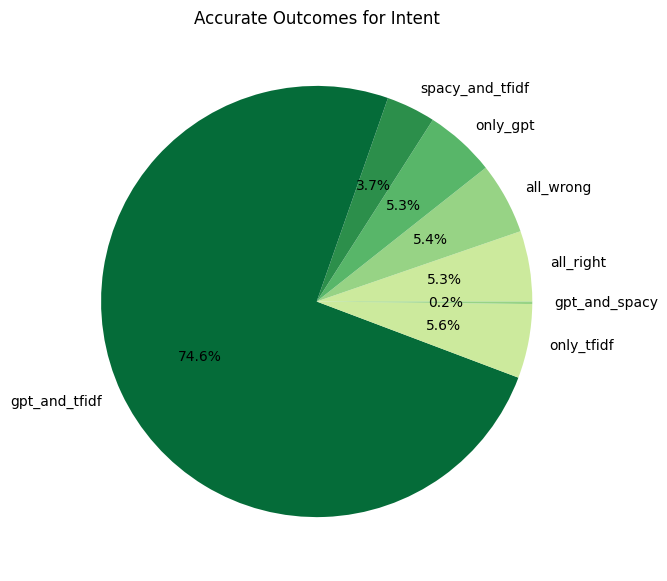

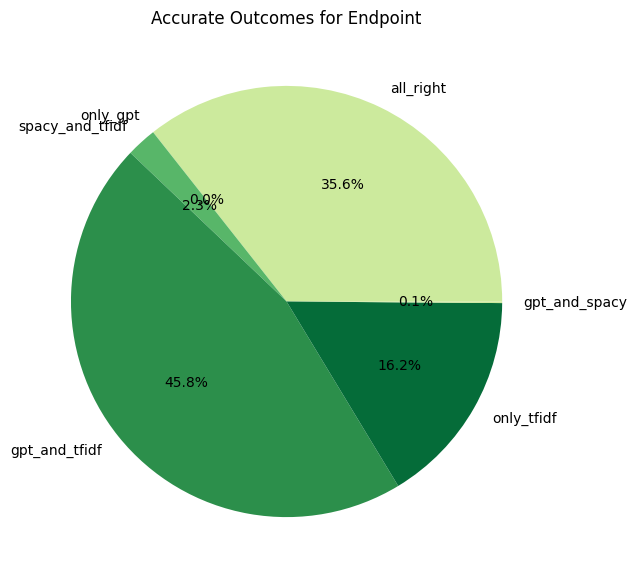

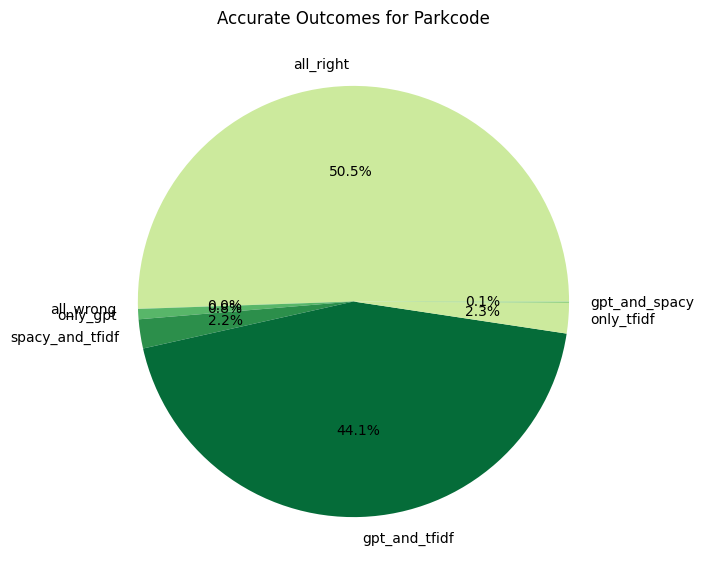

In [17]:
plot_errors(errors)

In [18]:
def find_wrong(df, metric, model):
    wrong = df.query(f'{metric}!={model}_{metric}')
    wrong = wrong[[metric, f'{model}_{metric}']].value_counts()

    return wrong

In [19]:
find_wrong(test_data, 'intent', 'gpt')

intent       gpt_intent 
fullname     alerts         933
description  state          749
             alerts         138
address      state           80
description  address         19
fullname     address          5
amenities    itiesities       4
description  error            4
amenities    error            3
description  information      3
amenities    alerts           2
fullname     description      2
             state            2
amenities    amen             1
description  fe               1
             ities            1
Name: count, dtype: int64

In [20]:
find_wrong(test_data, 'endpoint', 'gpt')

endpoint    gpt_endpoint   
feespasses  fees               4708
alerts      warnings              2
parks       amenities             2
events      :endpoint:            1
feespasses  :passespasses         1
            passesendpoint:       1
parks       affiliates            1
            alerts                1
            fees                  1
            grants                1
Name: count, dtype: int64

In [21]:
find_wrong(test_data, 'parkcode', 'gpt')

parkcode  gpt_parkcode
brcr      brc             64
cakr      cak             64
wicr      wic             64
tuzi      tuz             64
pefo      pef             64
olym      oly             64
ocmu      ocm             64
npsa      nps             64
kefj      kef             64
kaww      kaw             64
jomu      jom             64
jofl      jof             64
hofu      hof             64
hofr      hof             64
fopu      fop             64
fomr      fom             64
fomc      fom             64
fofr      fof             64
fobu      fob             64
cawo      caw             64
yuho      yu              64
mima      cama             1
Name: count, dtype: int64

In [22]:
find_wrong(test_data, 'intent', 'spacy')

intent       spacy_intent
amenities    other           5634
alerts       other           4695
events       other           4695
feespass     other           4695
description  other           3756
fullname     other           2817
address      other           1878
amenities    state             18
alerts       state             15
events       state             15
feespass     state             15
description  state             12
fullname     state              9
address      state              6
Name: count, dtype: int64

In [23]:
find_wrong(test_data, 'endpoint', 'spacy')


endpoint    spacy_endpoint
amenities   parks             5652
alerts      parks             4710
events      parks             4710
feespasses  parks             4710
Name: count, dtype: int64

In [24]:
find_wrong(test_data, 'parkcode', 'spacy')


parkcode  spacy_parkcode
adam      none              64
camo      none              63
glac      none              63
lode      none              63
voya      none              61
                            ..
fomc      none              32
foma      none              32
zion      none              32
grfa      none              20
kowa      none              20
Name: count, Length: 433, dtype: int64

In [25]:
find_wrong(test_data, 'intent', 'nltk')

intent       nltk_intent
amenities    other          5634
alerts       other          4695
events       other          4695
feespass     other          4695
description  other          3756
fullname     other          2817
address      other          1878
amenities    state            18
alerts       state            15
events       state            15
feespass     state            15
description  state            12
fullname     state             9
address      state             6
Name: count, dtype: int64

In [26]:
find_wrong(test_data, 'endpoint', 'nltk')

endpoint    nltk_endpoint
amenities   parks            5652
alerts      parks            4710
events      parks            4710
feespasses  parks            4710
Name: count, dtype: int64

In [27]:
find_wrong(test_data, 'parkcode', 'nltk')

parkcode  nltk_parkcode
gwmp      bawa             64
natr      bawa             64
abli      none             32
olsp      none             32
okci      none             32
                           ..
fosc      none             32
fora      none             32
fopu      none             32
fopo      none             32
zion      none             32
Name: count, Length: 470, dtype: int64

In [28]:
find_wrong(test_data, 'intent', 'tfidf')

intent       tfidf_intent
state        description     942
description  fullname        939
fullname     description     932
description  state            13
fullname     state             9
description  alerts            3
alerts       feespass          2
description  feespass          1
fullname     alerts            1
Name: count, dtype: int64

In [29]:
find_wrong(test_data, 'parkcode', 'tfidf')

parkcode  tfidf_parkcode
cham      lyba              4
anac      lyba              4
fowa      lyba              4
natc      lyba              4
bost      lyba              4
                           ..
colm      lyba              2
zion      lyba              2
natc      elte              1
bost      elca              1
colo      elca              1
Name: count, Length: 124, dtype: int64

In [30]:
find_wrong(test_data, 'endpoint', 'tfidf')

endpoint  tfidf_endpoint
parks     alerts            4
alerts    feespasses        2
parks     feespasses        1
Name: count, dtype: int64